Comment:

Inspiration 1 for Multi-label: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

Inspiration 2 for MultiLabelBinarizer = https://github.com/pnageshkar/NLP/blob/master/Medium/Multi_label_Classification_BERT_Lightning.ipynb

# **Libraries**

In [1]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U sentence-transformers
!pip install -q transformers
! pip install -q bs4
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer

from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import BertForSequenceClassification
import datasets


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# **Dataset**

In [5]:
df = pd.read_csv("/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/twsm_project_corpus0.csv")
df.head(5)
df = df.dropna() #drop na values (somehow a few remained in the dataset)
rejoined = [row.split(" ") for row in df.labels_str]
df["accept"] = rejoined
df.head(10)

,Unnamed: 0,text,accept,labels_str
0,0,The other part of our data consists of an undi...,[Data],Data
1,1,This list of actors can be interpreted to repr...,[Definition],Definition
2,2,The two samples were compared on all study var...,"[Method, Theory]",Method Theory
3,3,This is supported by a more recent report by ...,[RelationToLiterature],RelationToLiterature
4,4,", the false noise parameter C was misstated by...",[Definition],Definition
5,5,"In the strategic management literature, the na...",[RelationToLiterature],RelationToLiterature
6,6,"No such link was found however, but, according...",[FutureWork],FutureWork
7,7,The problem is that the timeliness of the data...,"[Data, Limitation]",Data Limitation
8,8,The social sciences differ from the physical s...,[RelationToLiterature],RelationToLiterature
9,9,Browne et al. START_CITE [3] END_CITE CITE_b...,[RelationToLiterature],RelationToLiterature


## **Should we apply this pre_process?**

In [6]:
#@title
def pre_process(text):
  text = BeautifulSoup(text).get_text()
  # fetch alphabetic characters
  #text = re.sub("[^a-zA-Z]", " ", text)
  # convert text to lower case
  text = text.lower()
  # split text into tokens to remove whitespaces
  tokens = text.split()
  return " ".join(tokens)

In [7]:
#@title
df["clean_text"] = df["text"].apply(pre_process)

In [8]:
#@title
df["text"][3]

'This is supported by a more recent report by  START_CITE West and Curtis (2006) END_CITE  CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [9]:
#@title
df["clean_text"][3]

'this is supported by a more recent report by start_cite west and curtis (2006) end_cite cite_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

## **Max_len decision**

Text(0, 0.5, 'Word count')

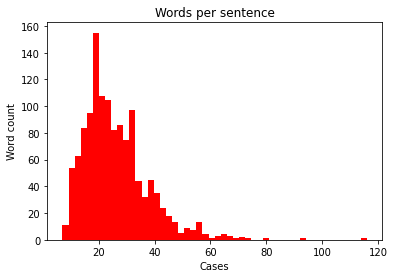

In [10]:
#Count words per sentence so we can set an appropiate max_len. In this case, 200 will be more than enough.
word_list = [len(x.split()) for x in df["text"].tolist()]
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
n, bins, patches = ax.hist(word_list, bins=50, histtype='bar')

#ax.set_xticklabels([n], rotation='vertical')

for patch in patches:
    patch.set_facecolor('r')

plt.title("Words per sentence")
plt.xlabel('Cases')
plt.ylabel('Word count')


In [11]:
# Set the maximum sequence length.
max_length = 200

## **Encode labels**

In [12]:
#MultiLabelBinarizer (https://github.com/pnageshkar/NLP/blob/master/Medium/Multi_label_Classification_BERT_Lightning.ipynb)
mlb = MultiLabelBinarizer()
accept_MLB = mlb.fit_transform(df["accept"])
# Getting a sense of how the tags data looks like
print(accept_MLB[0])
print(mlb.inverse_transform(accept_MLB[0].reshape(1,-1)))
print(mlb.classes_)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[('Data',)]
['Contribution' 'Data' 'Definition' 'EmpiricalResult' 'FutureWork' 'Goal'
 'Hypothesis' 'HypothesisResult' 'Item' 'Limitation' 'Method' 'Motivation'
 'RelationToLiterature' 'ResearchQuestion' 'Theory']


## **Training, validation and test set**

In [13]:
# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(df["text"], accept_MLB, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)

# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

## **Tokenize**

In [14]:
checkpoint = "bert-large-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

OSError: ignored

In [ ]:
#x_train = tokenizer(list(x_train), padding=True, truncation=True, return_tensors="pt", max_length=200)
x_test = tokenizer(list(x_test), padding=True, truncation=True, return_tensors="pt", max_length=200)
x_tr = tokenizer(list(x_tr), padding=True, truncation=True, return_tensors="pt", max_length=200)
x_val = tokenizer(list(x_val), padding=True, truncation=True, return_tensors="pt", max_length=200)

In [ ]:
x_tr

In [ ]:
####batch["labels"] = torch.tensor([1, 1])

#optimizer = AdamW(model.parameters())
#loss = model(**batch).loss
#loss.backward()
#optimizer.step()

## **Create DatasetDict**

In [ ]:
dataset_dict = datasets.DatasetDict({"train":(x_tr,y_tr),"test":(x_test,y_test),"validation":(x_val,y_val)})

In [ ]:
dataset_dict["train"][0]

# **Train model**

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-large-cased", num_labels=15, problem_type="multi_label")
batch_size = 8
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-large-cased",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

vvv With Pytorch Lightning Trainer (not working) vvv

## **Preparing Dataset and DataModule**

In [ ]:
#@title
class STagDataset (Dataset):
    def __init__(self,sent,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = sent
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

In [ ]:
#@title
class STagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage = None):
        if stage == "fit" or stage is None:
          self.train_dataset = STagDataset(sent=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
          self.val_dataset  = STagDataset(sent=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        if stage == "test" or stage is None:
          self.test_dataset  = STagDataset(sent=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16)

In [ ]:
#@title
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-large-uncased" # BERT Large with uncased text
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
#@title
sent_cnt = 0

# For every sentence...
for sentence in df["text"]:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(sentence, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        sent_cnt +=1

print(f'# Sentences having word count > {max_word_cnt}: is  {sent_cnt}')

In [ ]:
#@title
# Parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 16
MAX_LEN = 200
LR = 2e-05

In [ ]:
#@title
# Instantiate and set up the data_module
STdata_module = STagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
STdata_module.setup(stage="train")

# **Model Training**

Setup the Multi-label Classifier Model - dervived from LightningModule , similar to nn.module of PyTorch

In [ ]:
#@title
class STagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=10, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [ ]:
#@title
# Instantiate the classifier model
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = STagClassifier(n_classes=10, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

In [ ]:
#@title
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/STag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='STag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [ ]:
#@title
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)
#trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 1,progress_bar_refresh_rate = 30)

In [ ]:
#@title
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
#@title
# Train the Classifier Model
trainer.fit(model, STdata_module)

In [ ]:
#@title
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=STdata_module)

In [ ]:
#@title
# Visualize the logs using tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

# **Evaluate Model Performance on Test Set**

In [ ]:
#@title
# Retreive the checkpoint path for best model
model_path = checkpoint_callback.best_model_path
model_path

In [ ]:
#@title
len(y_test), len(x_test)

In [ ]:
#@title
# Size of Test set
print(f'Number of sentences = {len(x_test)}')

## **Setup test dataset for BERT**

In [ ]:
#@title
from torch.utils.data import TensorDataset

# Tokenize all sentences in x_test
input_ids = []
attention_masks = []


for sent in x_test:
    encoded_sent =  Bert_tokenizer.encode_plus(
                    sent,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded sentence to the list.    
    input_ids.append(encoded_sent['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_sent['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)

In [ ]:
#@title
#pred_data[0]

In [ ]:
#@title
#len(pred_dataloader.dataset)

## **Prediction on test set**

In [ ]:
#@title
flat_pred_outs = 0
flat_true_labels = 0

In [ ]:
#@title
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)

In [ ]:
#@title
pred_outs[0][0]

In [ ]:
#@title
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
#@title
flat_pred_outs.shape , flat_true_labels.shape

## **Predictions of Tags in Test set**

In [ ]:
#@title
#define candidate threshold values
threshold  = np.arange(0.4,0.51,0.01)
threshold

In [ ]:
#@title
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

In [ ]:
#@title
flat_pred_outs[3]

In [ ]:
#@title
flat_true_labels[3]

In [ ]:
#@title
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

for thresh in threshold:
    
    #classes for each threshold
    pred_bin_label = classify(flat_pred_outs,thresh) 

    #convert to 1D array
    y_pred = np.array(pred_bin_label).ravel()

    scores.append(metrics.f1_score(y_true,y_pred))

In [ ]:
#@title
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

In [ ]:
#@title
#y_true = flat_true_labels.ravel() 

In [ ]:
#@title
#y_true

In [ ]:
#@title
#flat_true_labels

## **Performance Score Evaluation**

In [ ]:
#@title
#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,opt_thresh)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [ ]:
#@title
print(metrics.classification_report(y_true,y_pred))

In [ ]:
#@title
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [ ]:
#@title
df.sample(10)

# **Inference**

In [ ]:
#@title
# load a model along with its weights, biases and hyperparameters
STmodel = STagClassifier.load_from_checkpoint(model_path)
STmodel.eval()

In [ ]:
#@title
#Function to Predict Tags from a sentence
def predict(sentence):
    text_enc = Bert_tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length= MAX_LEN,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'      
    )
    outputs = STmodel(text_enc['input_ids'], text_enc['attention_mask'])
    pred_out = outputs[0].detach().numpy()
    #print(f'Outputs = {outputs}')
    #print(f'Type = {type(outputs)}')
    #print(f'Pred Outputs = {pred_out}')
    #print(f'Type = {type(pred_out)}')
    #preds = np.round(pred_out)
    preds = [(pred > opt_thresh) for pred in pred_out ]
    #pred_list = [ round(pred) for pred in pred_logits ]
    preds = np.asarray(preds)
    #print(f'Predictions = {preds}')
    #print(f'Type = {type(preds)}')
    #print(mlb.classes_)
    new_preds = preds.reshape(1,-1).astype(int)
    #print(new_preds)
    pred_tags = mlb.inverse_transform(new_preds)
    #print(mlb.inverse_transform(np.array(new_preds)))
    return pred_tags 

# **Try the model**

In [ ]:
#@title
# Your sentence stored in the sentence variable
sentence = "based on the following relationship between matthew s correlation coefficient mcc and chi square mcc is the pearson product moment correlation coefficient is it possible to conclude that by having imbalanced binary classification problem n and p df following mcc is significant mcc sqrt which is mcc when comparing two algorithms a b with trials of times if mean mcc a mcc a mean mcc b mcc b then a significantly outperforms b thanks in advance edit roc curves provide an overly optimistic view of the performance for imbalanced binary classification regarding threshold i m not a big fan of not using it as finally one have to decide for a threshold and quite frankly that person has no more information than me to decide upon hence providing pr or roc curves are just for the sake of circumventing the problem for publishing"

# Call the predict function to predict the associated Tags
tags = predict(sentence)
if not tags[0]:
    print('This sentence can not be associated with any known tag - Please review to see if a new tag is required ')
else:
    print(f'Following Tags are associated : \n {tags}')